# Homework 10

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt 
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

## Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

#### Gaussian Processes and Stochastic Processes
A stochastic process is defined as a mathematical object consisting of a family random variables occupying a probability space in which the index of the family is associated with time. They are used to model systems that seem to vary in a random manner. A Gaussian process is a type of stochastic process where a finite collection of points follows a multivariate normal distribution. The distribution of the Gaussian process is the joint distribution of those random variables. We can define a Gaussian Process by:

- A mean function: $m(x)$
- A covariance function (kernel): $k(x, x')$

Any finite set $[f(x_1), ... , f(x_n)]$ follows a multivariate Gaussian $f ~ N(m(X), K(X))$ where $X$ is the matrix with input vectors $x_1, ... , x_n$ and $K$ is the covariance matrix calculated from the kernel.

#### Variational Inference with Evidence Lower Bound (ELBO)

Variational Inference is a method used when it is too difficult to calculate the posterior distribution, $p(\theta | x)$. Instead of calculating the posterior directly, we optimize to find a distribution $q(\theta)$ from a family of distributions $Q$ that is close to the posterior distribution we want. We quantify this closeness with the Kullback-Leibler (KL) divergence, $KL(q(\theta)||p(\theta) | x)$, which measures how different the 2 probability distributions are. By minimizing the KL divergence, we get a better approximation of the posterior distribution. However, it can also be difficult to directly compute this, so ELBO is used instead to maximize a lower bound. The expression for ELBO is as follows: <br>

ELBO = $\mathbb{E}_q(\theta) [log p(x, \theta)] - \mathbb{E}_q(\theta) [log q(\theta)]$

Maximizing ELBO approximates minimizing the KL divergence between distributions $q(\theta)$ and the posterior distribution.

## Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

Reference: https://www.pymc.io/projects/examples/en/latest/gallery.html#gaussian-processes

### Import Dataset

Dataset Source: https://www.kaggle.com/datasets/sacramentotechnology/sleep-deprivation-and-cognitive-performance

In this question, we use Gaussian Processes in Bayesian regression for this dataset on sleep deprivation and quality performance. In particular, the dependent variable is PVT Reaction Time, with Sleep Hours, Emotion Regulation Score, N Back Accuracy, Stroop Task Reaction Time, and Stress Level as the predictors.

In [4]:
df = pd.read_csv("sleep_deprivation_dataset_detailed.csv")
df

,Participant_ID,Sleep_Hours,Sleep_Quality_Score,Daytime_Sleepiness,Stroop_Task_Reaction_Time,N_Back_Accuracy,Emotion_Regulation_Score,PVT_Reaction_Time,Age,Gender,BMI,Caffeine_Intake,Physical_Activity_Level,Stress_Level
0,P1,5.25,15,12,1.60,64.20,12,365.85,35,Female,30.53,2,1,33
1,P2,8.70,12,14,2.54,65.27,21,288.95,20,Male,27.28,3,8,37
2,P3,7.39,17,10,3.40,74.28,35,325.93,18,Male,30.00,1,2,32
3,P4,6.59,14,3,3.54,72.42,25,276.86,18,Male,34.47,5,0,23
4,P5,3.94,20,12,3.09,99.72,60,383.45,36,Male,29.70,3,4,14
5,P6,3.94,12,6,2.84,58.80,46,224.48,28,Male,32.23,3,6,29
6,P7,3.35,8,18,3.16,50.90,31,201.56,22,Male,32.74,4,5,16
7,P8,8.20,14,21,3.28,74.69,66,388.37,29,Male,32.25,1,0,4
8,P9,6.61,12,1,1.74,58.94,38,258.28,20,Female,25.24,3,4,28
9,P10,7.25,0,9,2.61,68.32,23,221.28,18,Male,21.78,3,4,3


### Modelling in PyMC

In [22]:
columns_to_use = [
    'Sleep_Hours',
    'Emotion_Regulation_Score',
    'N_Back_Accuracy',
    'Stroop_Task_Reaction_Time',
    'Stress_Level',
    'PVT_Reaction_Time'
]

df_subset = df[columns_to_use].dropna() 

X = df_subset.drop(columns='PVT_Reaction_Time')
y = df_subset['PVT_Reaction_Time'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1,1)).flatten()

# Final check: dimensions and preview
X_scaled[:5]
print("Standardized y (first 5):", y_scaled[:5])

Standardized y (first 5): [ 0.38259681 -0.50064581 -0.07590833 -0.63950671  0.58474337]


In [23]:
X_input = X_scaled
y_input = y_scaled

In [24]:
np.random.seed(42)

with pm.Model() as gp_model:
    lengthscale = pm.Gamma("lengthscale", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=1)

    # kernel
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=X_input.shape[1], ls=lengthscale)

    # gaussian process prior
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfNormal("sigma", sigma=1)

    y_obs = gp.marginal_likelihood("y_obs", X=X_input, y=y_input, noise=sigma)

    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.9, return_inferencedata=True)
    

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lengthscale, eta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.


### Diagnostics

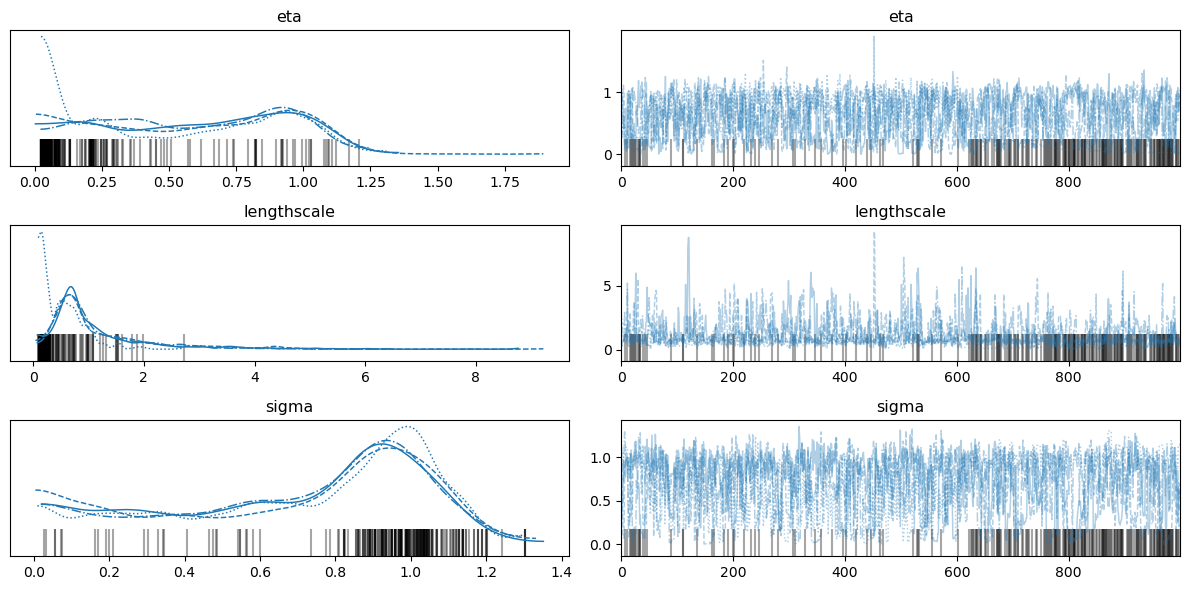

In [25]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

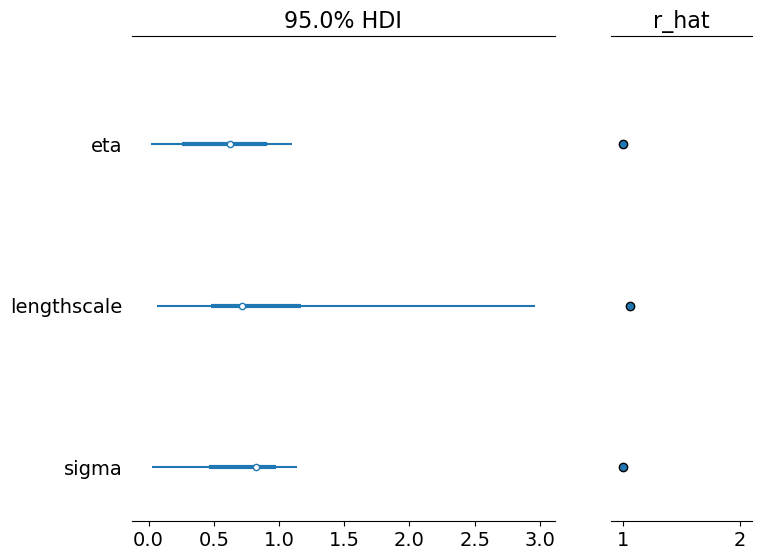

In [26]:
az.plot_forest(trace, 
               combined=True, hdi_prob=0.95, r_hat=True);

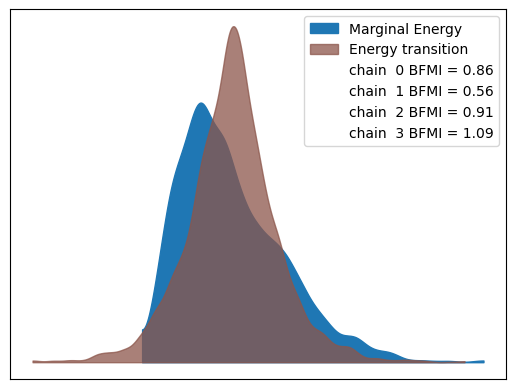

In [27]:
az.plot_energy(trace);

### Post Predictive Sampling

Sampling: [y_obs]


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


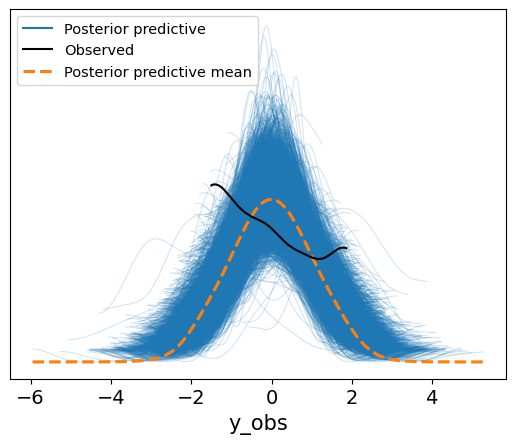

In [28]:
with gp_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

az.plot_ppc(ppc)
plt.show()

### Bayesian Inference

In [36]:
az.summary(trace, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,0.58978,0.35321,0.00889,1.07524,0.06200,0.01996,34.31637,46.47101,1.08011
lengthscale,1.00313,0.93794,0.06769,2.73876,0.13925,0.04650,15.38086,28.05452,1.18900
sigma,0.71131,0.33265,0.02093,1.12000,0.03765,0.00774,61.83692,536.82250,1.04814


### Discussion

For this question, Gaussian processes were used in Bayesian regression to predict PVT (Psychomotor Vigilance Test) Reaction Time given a variety of predictors: number of hours slept; emotional regulation; N-Back accuracy, where the N-back test is a cognitive test in which participants are given a series of objects and must decide if the current object matches one presented 'n' times back in the series; reaction times for the Stroop task, where participants are given a list of colour names, some printed in the corresponding colour and some not, and they must name the colour of the ink; and stress levels. 

Overall, there are some points of concern that could not be addressed due to time constraints.

## Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

Reference: https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html

### Import Dataset

Source: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

For this question, we will try to predict the quality of a red wine given its chemical properties, such as its citric acid content, density, pH, free sulfur dioxide content, and more. 

In [3]:
df2 = pd.read_csv('winequality-red.csv')
df2

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Training Model with PyMC

In [10]:
X = df2.drop("quality", axis=1)
y = df2["quality"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

In [5]:
n_hidden = 5
batch_size = 64
coords = {
    "train_cols": np.arange(X_train.shape[1]),
    "hidden_layer_1": np.arange(n_hidden),
    "hidden_layer_2": np.arange(n_hidden),
}

rng = np.random.default_rng(seed=42)
init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(np.float32)
init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(np.float32)
init_out = rng.standard_normal(size=n_hidden).astype(np.float32)

with pm.Model(coords=coords) as bnn_model:
    X_data = pm.Data("X_data", X_train, dims=("batch", "train_cols"), mutable=True)
    Y_data = pm.Data("Y_data", y_train_scaled, dims="batch", mutable=True)

    x_in, y_in = pm.Minibatch(X_data, Y_data, batch_size=batch_size)

    # priors
    w_in_1 = pm.Normal("w_in_1", mu=0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1"))
    w_1_2 = pm.Normal("w_1_2", mu=0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2"))
    w_2_out = pm.Normal("w_2_out", mu=0, sigma=1, initval=init_out, dims="hidden_layer_2")

    # forward pass for neural network
    act_1 = pm.math.tanh(pt.dot(x_in, w_in_1))
    act_2 = pm.math.tanh(pt.dot(act_1, w_1_2))
    act_out = pt.dot(act_2, w_2_out)

    # likelihood
    sigma = pm.HalfNormal("sigma", sigma=1)
    out = pm.Normal("out", mu=act_out, sigma=sigma, observed=y_in, total_size=X_train.shape[0])

    # ADVI for variational inference w/ ELBO
    approx = pm.fit(n=30000, method="advi", progressbar=True)
    trace = approx.sample(draws=1000)

Finished [100%]: Average Loss = 84.151
/opt/conda/lib/python3.11/site-packages/pymc/backends/arviz.py:60: UserWarning: Could not extract data from symbolic observation out
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [11]:
print(trace)

Inference data with groups:
	> posterior
	> constant_data


### Prediction Model from Trained Trace

/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [out]


KeysView(Inference data with groups:
	> posterior_predictive
	> constant_data)


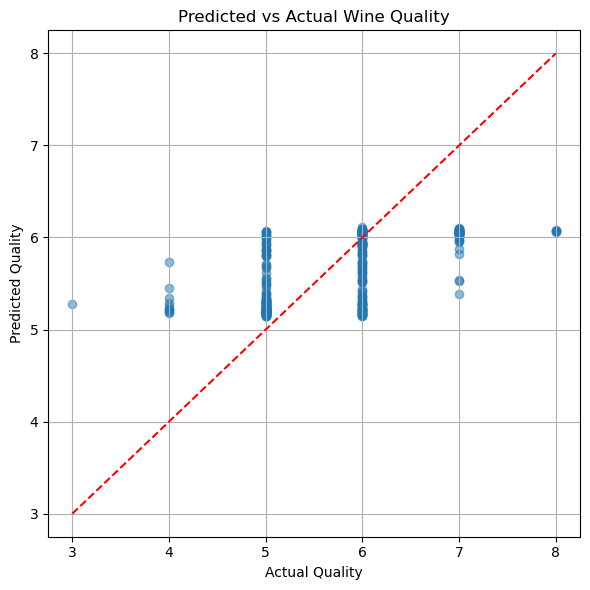

In [18]:
w_in_1_mean = trace.posterior["w_in_1"].mean(dim=("chain", "draw")).values
w_1_2_mean = trace.posterior["w_1_2"].mean(dim=("chain", "draw")).values
w_2_out_mean = trace.posterior["w_2_out"].mean(dim=("chain", "draw")).values
sigma_mean = trace.posterior["sigma"].mean(dim=("chain", "draw")).values.item()

coords_pred = {
    "train_cols": np.arange(X_test.shape[1]),
    "hidden_layer_1": np.arange(n_hidden),
    "hidden_layer_2": np.arange(n_hidden),
}

with pm.Model(coords=coords_pred) as prediction_model:
    X_data_pred = pm.Data("X_data_pred", X_test, dims=("batch", "train_cols"))

    w_in_1 = pm.Normal("w_in_1", mu=w_in_1_mean, sigma=1e-6, dims=("train_cols", "hidden_layer_1"))
    w_1_2 = pm.Normal("w_1_2", mu=w_1_2_mean, sigma=1e-6, dims=("hidden_layer_1", "hidden_layer_2"))
    w_2_out = pm.Normal("w_2_out", mu=w_2_out_mean, sigma=1e-6, dims="hidden_layer_2")
    sigma = pm.HalfNormal("sigma", sigma=sigma_mean)

    act_1 = pm.math.tanh(pt.dot(X_data_pred, w_in_1))
    act_2 = pm.math.tanh(pt.dot(act_1, w_1_2))
    act_out = pt.dot(act_2, w_2_out)

    out = pm.Normal("out", mu=act_out, sigma=sigma, shape=X_test.shape[0])

    ppc_pred = pm.sample_posterior_predictive(trace, var_names=["out"], random_seed=42)


print(ppc_pred.keys())

y_pred_scaled = ppc_pred.posterior_predictive["out"].mean(dim=("chain", "draw")).values  
y_pred = y_pred_scaled * y_std + y_mean

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual Wine Quality")
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizations

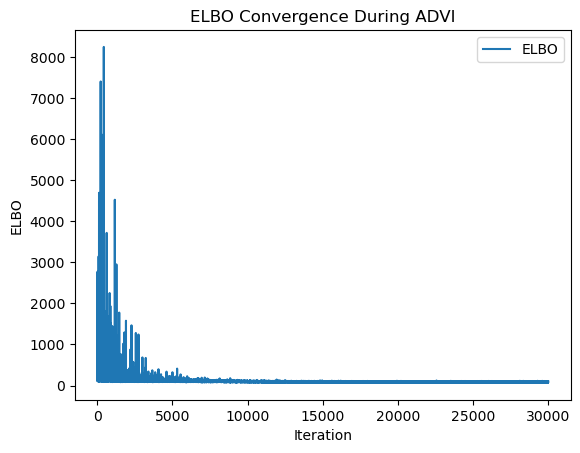

In [19]:
plt.plot(approx.hist, label="ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Convergence During ADVI")
plt.legend()
plt.show()

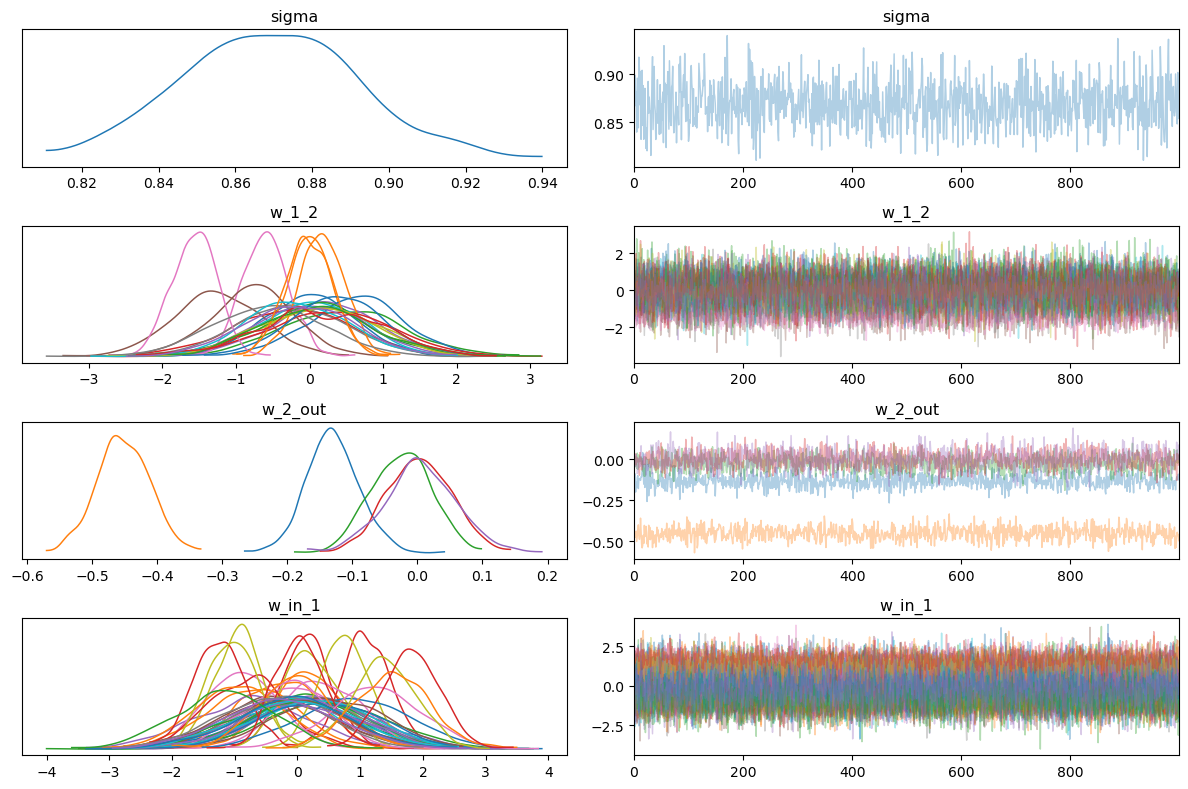

In [26]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [27]:
with prediction_model:
    ppc_pred = pm.sample_posterior_predictive(trace, var_names=["out"], random_seed=42)

Sampling: [out]


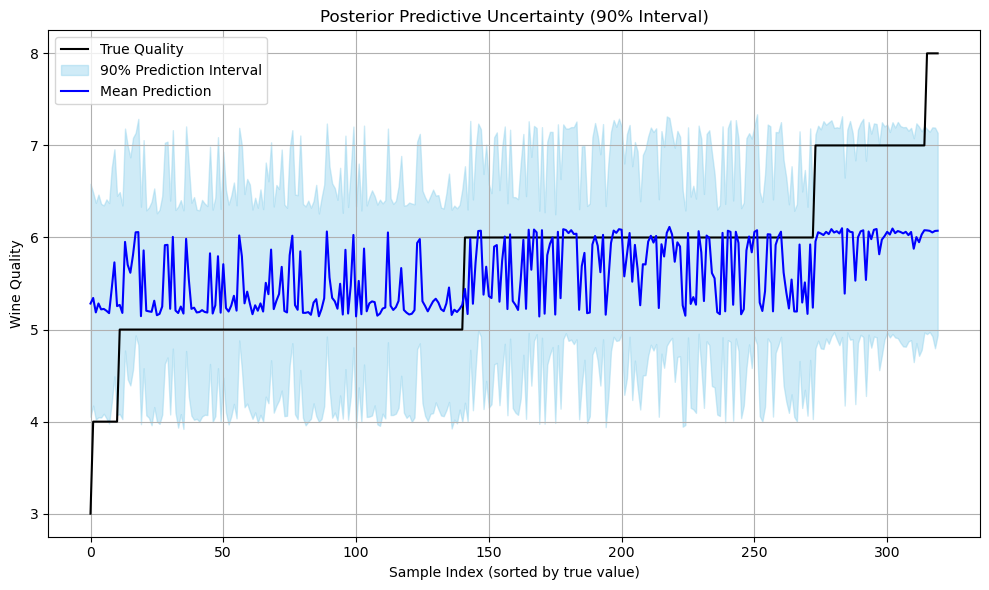

In [28]:
y_preds_scaled = ppc_pred.posterior_predictive["out"].values  
y_preds_scaled = y_preds_scaled.reshape(-1, y_preds_scaled.shape[-1]) 
y_preds = y_preds_scaled * y_std + y_mean 

sorted_idx = np.argsort(y_test.values)
sorted_y_test = y_test.values[sorted_idx]
sorted_y_preds = y_preds[:, sorted_idx]

lower = np.percentile(sorted_y_preds, 5, axis=0)
upper = np.percentile(sorted_y_preds, 95, axis=0)
mean_pred = np.mean(sorted_y_preds, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(sorted_y_test, label="True Quality", color="black")
plt.fill_between(np.arange(len(sorted_y_test)), lower, upper, color="skyblue", alpha=0.4, label="90% Prediction Interval")
plt.plot(mean_pred, label="Mean Prediction", color="blue")
plt.xlabel("Sample Index (sorted by true value)")
plt.ylabel("Wine Quality")
plt.title("Posterior Predictive Uncertainty (90% Interval)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

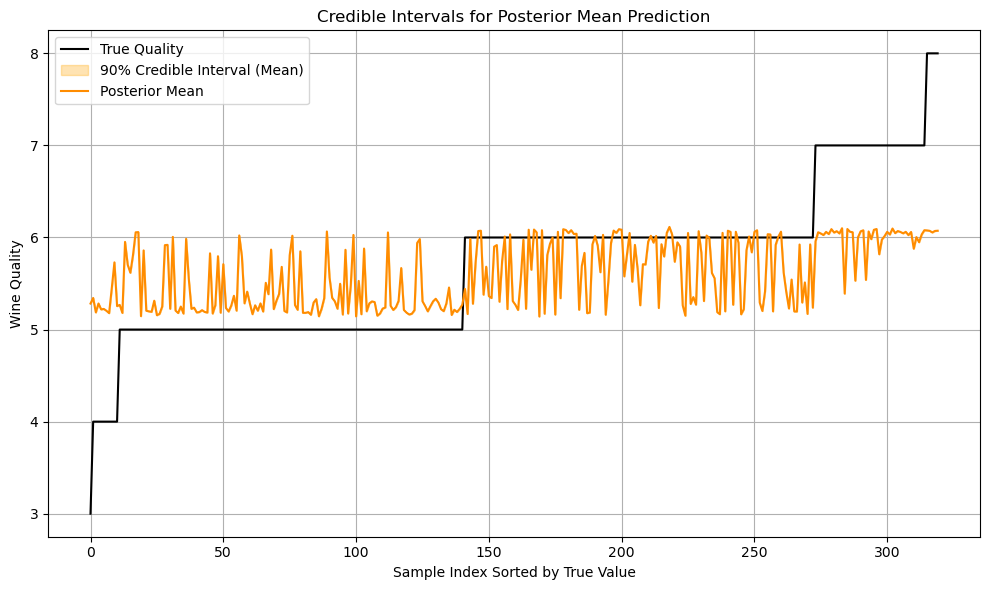

In [32]:
mu_draws = ppc_pred.posterior_predictive["out"].mean(dim="draw").values 
mu_draws = mu_draws.reshape(-1, mu_draws.shape[-1])  

mu_draws_destd = mu_draws * y_std + y_mean

sorted_idx = np.argsort(y_test.values)
sorted_y_test = y_test.values[sorted_idx]
sorted_mu_draws = mu_draws_destd[:, sorted_idx]

mu_lower = np.percentile(sorted_mu_draws, 5, axis=0)
mu_upper = np.percentile(sorted_mu_draws, 95, axis=0)
mu_mean = np.mean(sorted_mu_draws, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(sorted_y_test, label="True Quality", color="black")
plt.fill_between(np.arange(len(sorted_y_test)), mu_lower, mu_upper, color="orange", alpha=0.3, label="90% Credible Interval (Mean)")
plt.plot(mu_mean, label="Posterior Mean", color="darkorange")
plt.xlabel("Sample Index Sorted by True Value")
plt.ylabel("Wine Quality")
plt.title("Credible Intervals for Posterior Mean Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Bayesian Inference

In [30]:
az.summary(trace, round_to=5)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.86915,0.02304,0.82517,0.91340,0.00074,0.00050,977.23650,982.79917,NaN
"w_1_2[0, 0]",0.00051,0.62241,-1.14704,1.19324,0.01982,0.01462,988.12388,907.04368,NaN
"w_1_2[0, 1]",0.00110,0.33371,-0.66919,0.55362,0.01059,0.00815,996.51415,821.57420,NaN
"w_1_2[0, 2]",0.45248,0.82463,-1.01357,2.01416,0.02483,0.01996,1094.81911,834.98375,NaN
"w_1_2[0, 3]",-0.25293,0.80079,-1.72790,1.25677,0.02591,0.01766,949.59469,907.70126,NaN
...,...,...,...,...,...,...,...,...,...
"w_in_1[10, 0]",-0.10348,0.89931,-2.10714,1.36041,0.02924,0.02037,941.06930,853.89051,NaN
"w_in_1[10, 1]",1.50622,0.60704,0.26074,2.56983,0.01919,0.01556,1005.28178,840.28184,NaN
"w_in_1[10, 2]",-1.15515,0.78315,-2.63966,0.22716,0.02527,0.01694,962.10132,944.34114,NaN
"w_in_1[10, 3]",1.81672,0.45666,0.95893,2.60653,0.01515,0.01142,904.13755,814.65753,NaN


### Discussion